In [9]:
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load 
from scipy.sparse import save_npz, load_npz 
from sklearn.decomposition import NMF, LatentDirichletAllocation

from pathlib import Path
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

In [10]:
tweets_df = pd.read_csv('modified_processed_tweet_data.csv')
tweets_df.head(5)

,Unnamed: 0,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,place,statuses_count
0,38,Fri Apr 22 22:17:05 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,0,43,davideiacovozzi,18,55,NaN,NaN,281
1,39,Fri Apr 22 13:44:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175000,en,0,32,davideiacovozzi,18,55,NaN,NaN,281
2,41,Fri Apr 22 06:10:34 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,0,26,davideiacovozzi,18,55,False,NaN,281
3,42,Thu Apr 21 17:22:09 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,0,213,davideiacovozzi,18,55,NaN,NaN,281
4,43,Thu Apr 21 10:32:26 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,0,417,davideiacovozzi,18,55,False,NaN,281


In [24]:
cleaned_tweet = tweets_df[["original_text", "polarity"]]
cleaned_tweet

,original_text,polarity
0,RT @NorthstarCharts: The 10-year yield is tell...,0.16
1,RT @MichaelAArouet: German 10y mortgage rate w...,0.15
2,RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00
3,RT @charliebilello: The 30-year mortgage rate ...,0.00
4,RT @biancoresearch: Rates rise until something...,-0.40
...,...,...
16467,RT @CHARANJITCHANNI: Best wishes &amp; heartfe...,0.50
16468,RT @pbhushan1: Thank you @BajpayeeManoj for th...,0.85
16469,RT @s_shreyatweets: Agree ?👇 https://t.co/R54Z...,0.00
16470,RT @tejjINC: 1. Peace Yatra by Late Sunil Dutt...,-0.30


In [25]:
def text_category(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

In [26]:
cleaned_tweet["score"] = cleaned_tweet["polarity"].apply(text_category)
cleaned_tweet

C:\Users\dell\AppData\Local\Temp/ipykernel_18540/1163665108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_tweet["score"] = cleaned_tweet["polarity"].apply(text_category)


,original_text,polarity,score
0,RT @NorthstarCharts: The 10-year yield is tell...,0.16,positive
1,RT @MichaelAArouet: German 10y mortgage rate w...,0.15,positive
2,RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,neutral
3,RT @charliebilello: The 30-year mortgage rate ...,0.00,neutral
4,RT @biancoresearch: Rates rise until something...,-0.40,negative
...,...,...,...
16467,RT @CHARANJITCHANNI: Best wishes &amp; heartfe...,0.50,positive
16468,RT @pbhushan1: Thank you @BajpayeeManoj for th...,0.85,positive
16469,RT @s_shreyatweets: Agree ?👇 https://t.co/R54Z...,0.00,neutral
16470,RT @tejjINC: 1. Peace Yatra by Late Sunil Dutt...,-0.30,negative


In [27]:
sentiment = cleaned_tweet['score'].value_counts()
sentiment

neutral     7466
positive    6315
negative    2691
Name: score, dtype: int64

In [28]:
cleaned_tweet = cleaned_tweet[cleaned_tweet['score'] != 'neutral']
cleaned_tweet

,original_text,polarity,score
0,RT @NorthstarCharts: The 10-year yield is tell...,0.16,positive
1,RT @MichaelAArouet: German 10y mortgage rate w...,0.15,positive
4,RT @biancoresearch: Rates rise until something...,-0.40,negative
5,RT @LanceRoberts: Buying opportunities like th...,-0.10,negative
6,RT @MacroAlf: Welcome to September 2018.\n\nBo...,0.40,positive
...,...,...,...
16465,"RT @ozamizcps: PSSg Gedson Castañeros, Mobile ...",0.10,positive
16466,RT @Salt_Project_OS: Free yourself from writin...,0.40,positive
16467,RT @CHARANJITCHANNI: Best wishes &amp; heartfe...,0.50,positive
16468,RT @pbhushan1: Thank you @BajpayeeManoj for th...,0.85,positive


In [29]:
def scoremap(score):
    if score == "positive":
        return 1
    else:
        return 0

In [30]:
cleaned_tweet['scoremap'] = cleaned_tweet["score"].map(scoremap)
cleaned_tweet

C:\Users\dell\AppData\Local\Temp/ipykernel_18540/4128287711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_tweet['scoremap'] = cleaned_tweet["score"].map(scoremap)


,original_text,polarity,score,scoremap
0,RT @NorthstarCharts: The 10-year yield is tell...,0.16,positive,1
1,RT @MichaelAArouet: German 10y mortgage rate w...,0.15,positive,1
4,RT @biancoresearch: Rates rise until something...,-0.40,negative,0
5,RT @LanceRoberts: Buying opportunities like th...,-0.10,negative,0
6,RT @MacroAlf: Welcome to September 2018.\n\nBo...,0.40,positive,1
...,...,...,...,...
16465,"RT @ozamizcps: PSSg Gedson Castañeros, Mobile ...",0.10,positive,1
16466,RT @Salt_Project_OS: Free yourself from writin...,0.40,positive,1
16467,RT @CHARANJITCHANNI: Best wishes &amp; heartfe...,0.50,positive,1
16468,RT @pbhushan1: Thank you @BajpayeeManoj for th...,0.85,positive,1


In [37]:
(X, y) = cleaned_tweet['original_text'], cleaned_tweet['scoremap']

In [38]:
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X.values)

CountVectorizer(ngram_range=(1, 3))

In [39]:
X_trigram_vectorizer = trigram_vectorizer.transform(X.values)

In [40]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Test score: {round(test_score, 2)}\n')

In [41]:
train_and_show_scores(X_trigram_vectorizer, y.values, 'Trigram Counts')

Trigram Counts
Train score: 1.0 ; Test score: 0.86



## Topic Modelling using word cloud

In [13]:
stopwords = STOPWORDS
print(stopwords)

{'below', "didn't", 'themselves', "he'd", "won't", 'but', 'did', 'does', 'r', 'the', "can't", "here's", 'do', 'has', 'before', 'had', "she'd", 'such', "weren't", 'ourselves', 'them', 'own', "they've", "where's", "i'd", 'our', "mustn't", 'my', "she'll", 'over', 'each', 'are', 'further', 'otherwise', "haven't", 'so', 'theirs', 'com', 'been', 'once', 'were', 'both', 'since', "i've", 'get', 'yourself', 'him', 'of', 'be', "wouldn't", 'an', 'other', "it's", 'was', 'while', 'most', 'what', 'after', "doesn't", 'yourselves', 'or', 'with', 'on', 'it', 'into', 'from', 'nor', 'we', 'if', 'being', 'she', 'when', 'ought', 'am', 'is', 'then', 'having', 'k', 'would', 'have', 'a', 'up', "who's", 'too', 'myself', "you'll", 'ever', 'you', 'your', 'her', 'why', 'during', 'as', 'few', 'their', 'shall', 'between', 'off', 'some', 'cannot', "don't", "how's", "she's", 'they', 'should', 'hers', 'herself', 'however', 'http', 'this', 'that', "you'd", "we'd", 'more', "they're", 'by', 'could', "he's", 'for', "when'

In [16]:
wc = WordCloud(background_color="white", stopwords=stopwords, height=600, width=400)
wc.generate(tweets_df["original_text"])

TypeError: expected string or bytes-like object

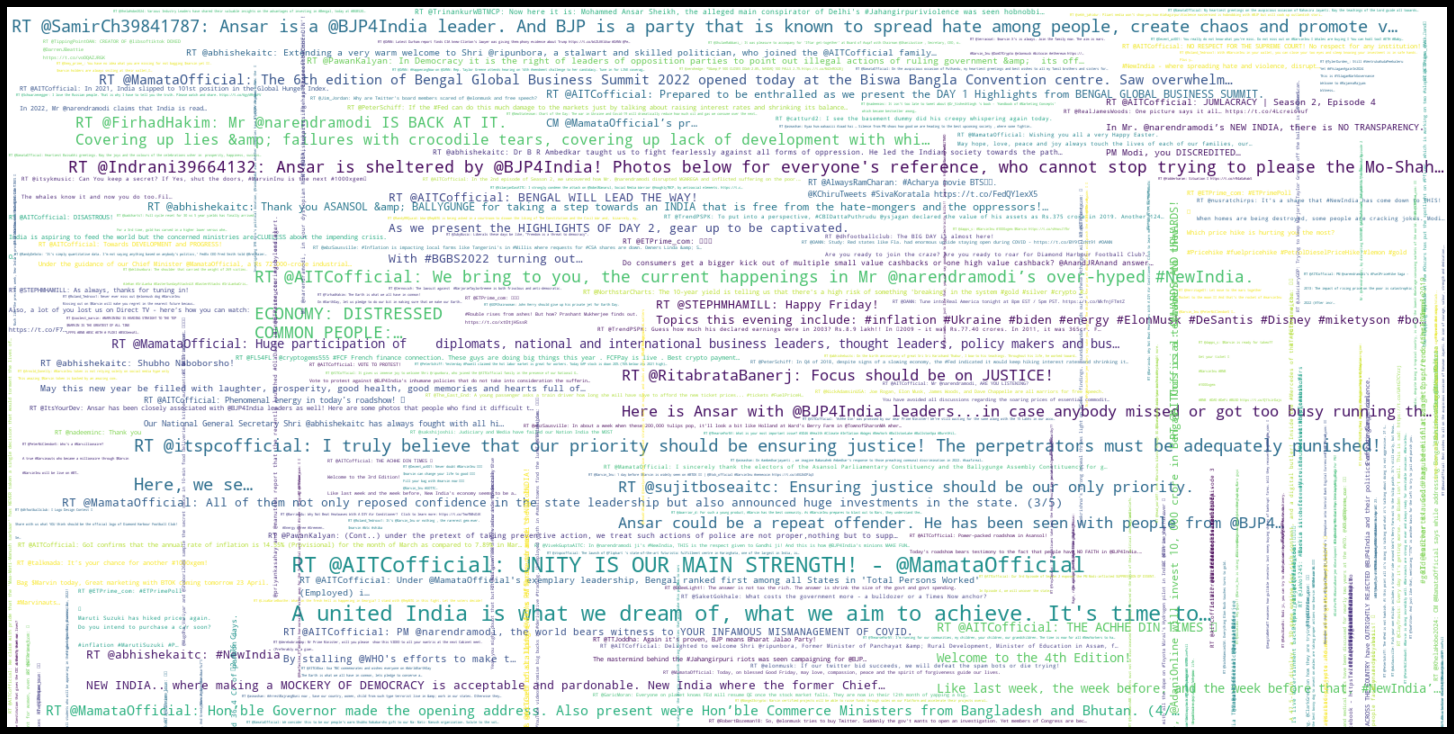

In [24]:
data = tweets_df["original_text"].value_counts().to_dict()
wc = WordCloud(width=1600, height=800, background_color="rgba(255, 255, 255, 0)").generate_from_frequencies(data)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
